In [2]:
import parse_gnps as pg
pg = reload(pg)
import parse_lipidblast as pl
import ClassificationTest
ClassificationTest = reload(ClassificationTest)
import ml
import numpy as np

from os import listdir
from os.path import isfile, join
import csv
import re
from collections import namedtuple

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

In [3]:
# read csv file of names
Map = namedtuple("Map", ("file_order", "name", "pubchem", 
                         "lipidmaps", "category", "main_class", 
                         "sub_class","common_name"))

with open('mcf_data/name_class_mapping.csv', 'rb') as csvfile:
    csv_file = csv.reader(csvfile)
    maps = [Map(*row) for row in csv_file]

# remove header line
maps = maps[1:]

In [4]:
# load spectra and clean file names to names

path = 'mcf_data'
mgf = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.mgf')]

spectra = [pg.raw_to_gnps_spectrum(open(join(path,f))) for f in mgf]
names = []

for f in mgf:
    # remove _[number] on some file names
    name = f.split(".mgf")[0].split("_")
    
    if name[-1].isdigit():
        name = '_'.join(name[0:-1])
    else:
        name = '_'.join(name)
    
    while not name.endswith(("NH4","C17", "C18")) and name[-1].isdigit():
        name = name[:-1]
        
    names.append(name)   

In [5]:
# use only those that can be matched and have a common name in the map
full_spectra, full_maps, full_names = [],[],[]
available_names = [m.name for m in maps]

for name, i in zip(names,range(len(names))):
    if name in available_names:
        key = available_names.index(name)
        if maps[key].common_name == '':
            print("No common name for {}".format(name))
        else:
            full_maps.append(maps[key])
            full_spectra.append(spectra[i])
            full_names.append(name)
    else:
        print("No entry for {}".format(name))

No common name for 1,2-Dierucoyl-sn-glycero-3-phosphoethanolamine
No common name for 25_0 Ceramide
No common name for 25_0 Ceramide
No common name for 25_0 Ceramide
No common name for 4-Cholesten-3-one
No common name for 4-Cholesten-3-one
No common name for 4-Cholesten-3-one
No common name for Arachidic acid_neg
No common name for Arachidonic acid_neg
No common name for Behenic acid _Docosanoic acid_neg
No common name for cis-4,7,10,13,16,19-Docosahexaenoic acid_neg
No common name for D-Sphingosine
No common name for D-Sphingosine
No common name for D-Sphingosine
No common name for D-Sphingosine
No common name for D-Sphingosine
No entry for D-Sphingosine__C17
No common name for Desmosterol
No common name for Dihydrosphingosine
No common name for Elaidic acid _neg
No common name for Erucic acid_neg
No common name for Glyceryl trioctanoateNH4
No common name for Hyodeoxycholic acid
No common name for Hyodeoxycholic acid
No common name for Lignoceric acid_Tetracosanoic acid_neg
No common n

In [6]:
# convert to compounds so that it can be classified
takepeaks = 1
compounds_test = [pl.Compound(m.common_name, None, 
                  float(s.weight[0]), None, None, 
                  list(s.mzs)[-takepeaks:], list(s.ints)[-takepeaks], None) 
                  for s, m in zip(full_spectra, full_maps)] 

In [7]:
len(compounds_test)

34

In [8]:
# read parse and filter lipidblast
fp = open("combined.txt")
compounds = pl.parse_all(fp.read(), sep='\n')
p = pl.unique_peaks(compounds)

classes_needed = ["DG", "PC", "SM", "TG","Cer-d"]
needed = [c for c in compounds if pl.assign_subclass(c) in classes_needed]
print len(needed)
print [np.sum([1 for c in needed if pl.assign_subclass(c) == l]) for l in classes_needed]

22960
[3528, 10952, 504, 7920, 56]


In [9]:
print [np.sum([1 for c in compounds_test if pl.assign_subclass(c) == l]) for l in classes_needed]

[1, 16, 3, 10, 4]


In [10]:
print [pl.assign_subclass(c) for c in compounds_test]

['PC', 'PC', 'PC', 'PC', 'PC', 'DG', 'PC', 'PC', 'PC', 'PC', 'PC', 'PC', 'PC', 'PC', 'PC', 'PC', 'SM', 'SM', 'SM', 'TG', 'TG', 'TG', 'TG', 'TG', 'TG', 'TG', 'TG', 'Cer-d', 'Cer-d', 'Cer-d', 'Cer-d', 'PC', 'TG', 'TG']


DG


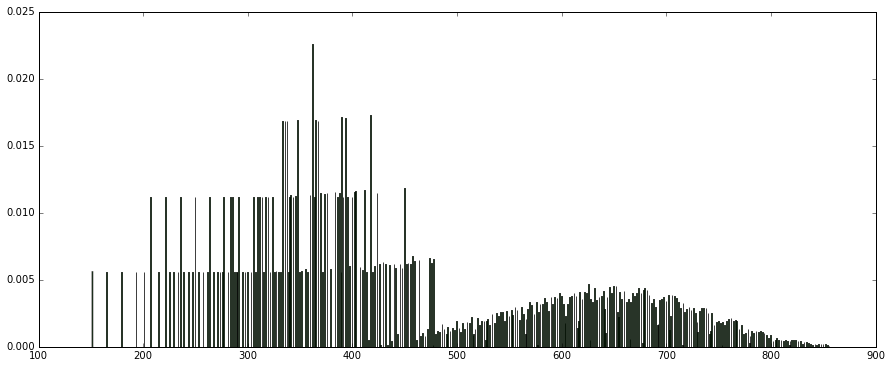

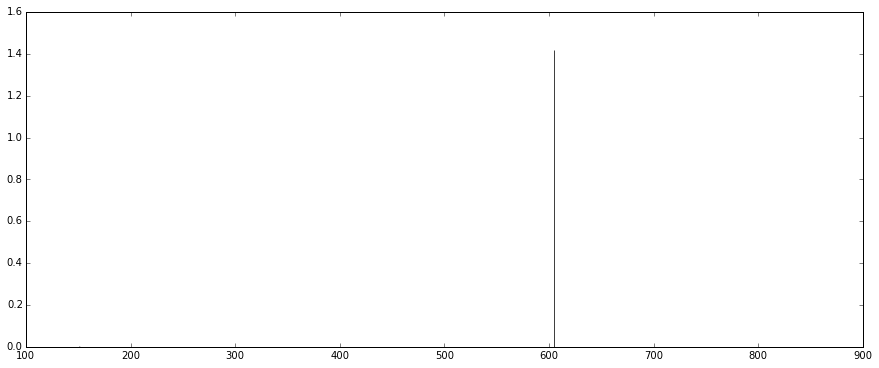

PC


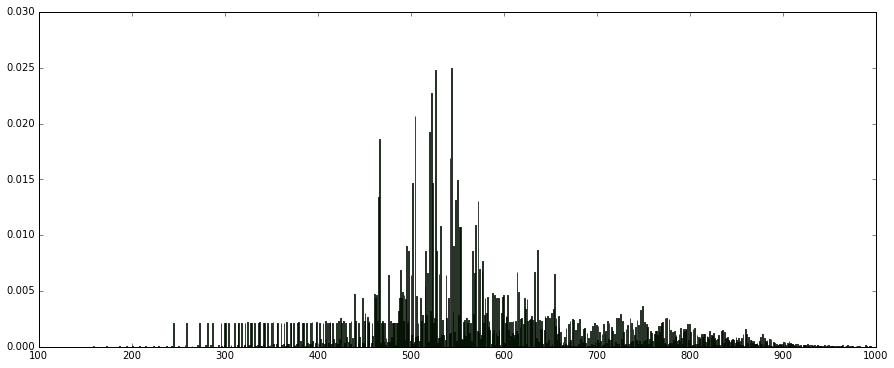

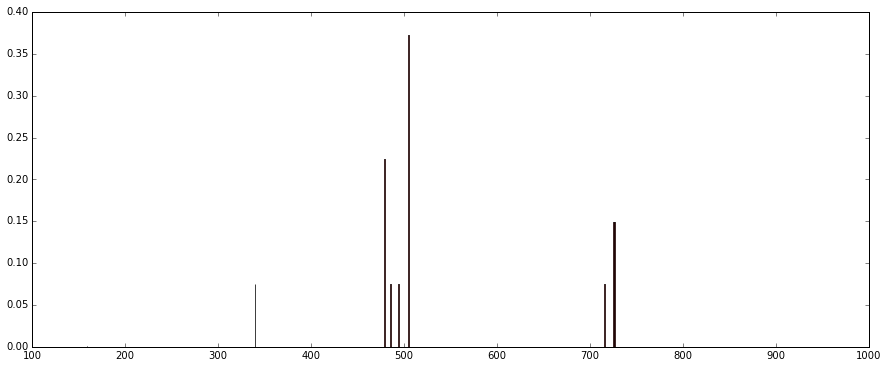

SM


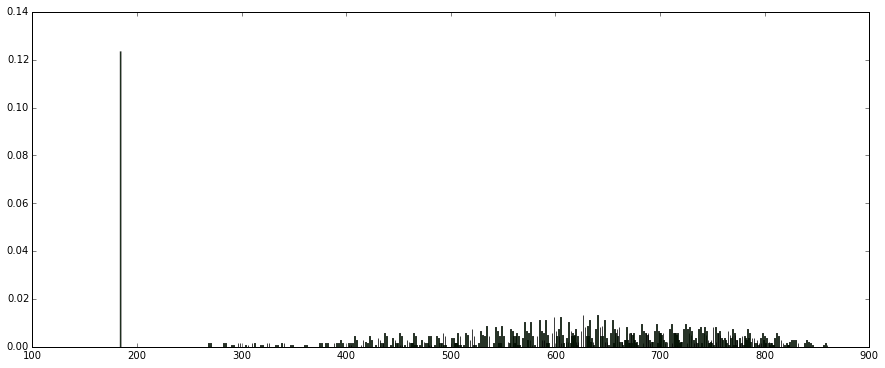

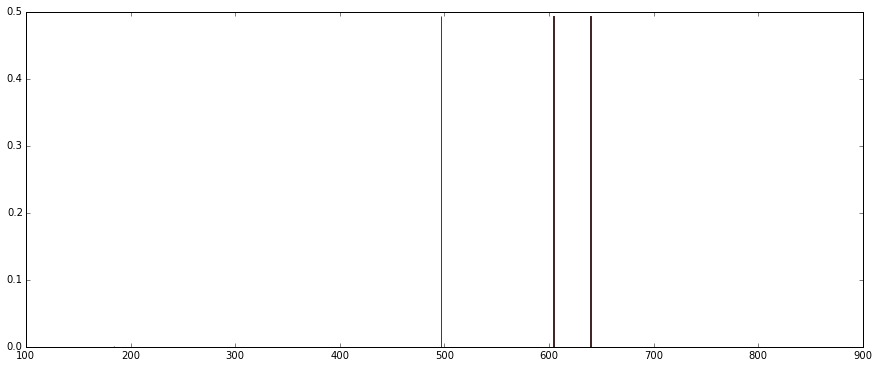

TG


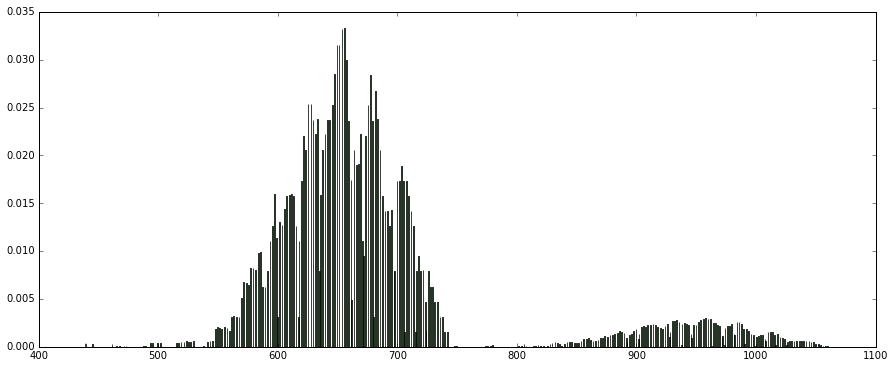

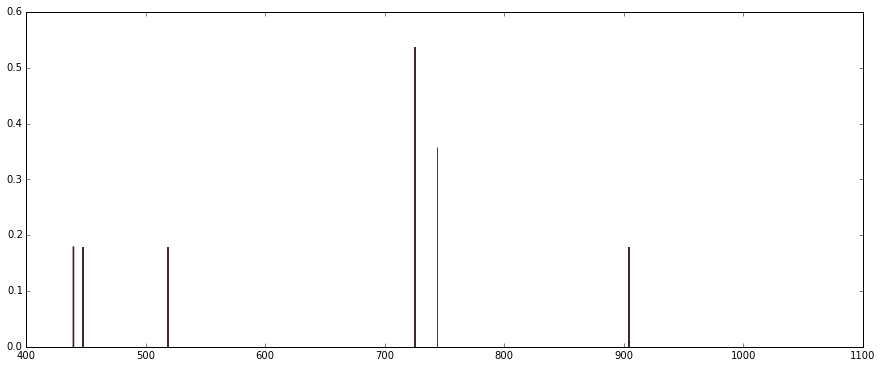

Cer-d


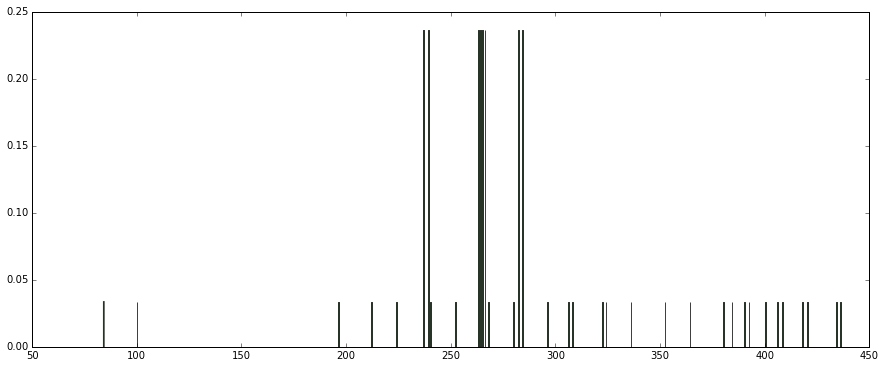

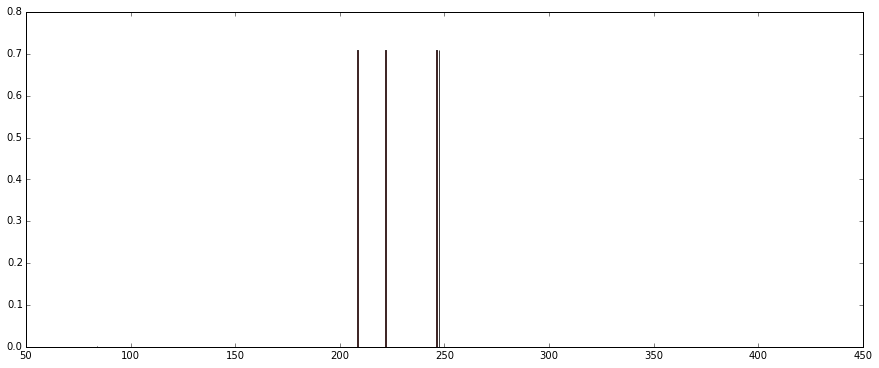

In [11]:
# get all peaks of a class in one diagram
masses = [[m for c in needed for m in c.mzs if pl.assign_subclass(c) == l] for l in classes_needed]
spectra_masses = [[m for c in compounds_test for m in c.mzs if pl.assign_subclass(c) == l] for l in classes_needed]

for l, m, ms in zip(classes_needed, masses, spectra_masses):
    print l
    n, bins, patches = plt.hist(m, 1000, normed = 1, facecolor='green', alpha=0.75)
    plt.show()
    n, bins, patches = plt.hist(ms, bins, normed=1, facecolor='red', alpha=0.75)
    plt.show()

In [12]:
# find direct matches of compoundds in real and simulated data
print [[ic, it] for ct,it in zip(compounds_test,range(len(compounds_test))) for c,ic in zip(needed,range(len(needed))) if ct.name == c.name]

[[16119, 33], [18759, 33], [21399, 33]]


In [13]:
print needed[16119]
print needed[18759]
print needed[21399]
print compounds_test[33]

Compound(name='TG(18:0/18:0/18:0)', id='TG 54:0', weight=897.84573, precursor_mz=897.84573, formula='C57H110O6', mzs=[613.57437], ints=[500.0], pk_comms=('[M+Li]-sn1+Li || [M+Li]-sn2+Li || [M+Li]-sn3+Li',))
Compound(name='TG(18:0/18:0/18:0)', id='TG 54:0', weight=913.81949, precursor_mz=913.81949, formula='C57H110O6', mzs=[629.54813], ints=[500.0], pk_comms=('[M+Na]-sn1+Na || [M+Na]-sn2+Na || [M+Na]-sn3+Na',))
Compound(name='TG(18:0/18:0/18:0)', id='TG 54:0', weight=908.86409, precursor_mz=908.86409, formula='C57H110O6', mzs=[891.86135, 607.56618], ints=[100.0, 500.0], pk_comms=('[M+NH4]-17', '[M+NH4]-sn1-18 || [M+NH4]-sn2-18 || [M+NH4]-sn3-18'))
Compound(name='TG(18:0/18:0/18:0)', id=None, weight=907.690526443894, precursor_mz=None, formula=None, mzs=[725.3859214], ints=7265.0787353516, pk_comms=None)


In [ ]:
from sklearn.naive_bayes import BernoulliNB
nb =BernoulliNB(alpha=0.017)

1,2-Dierucoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformation_test': {'round': None}} (started Thu Mar 03 23:14:07 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': None},{'round': None}
Adding noise {} and transformation {'round': None} to the feature space
Adding noise {} and transformation {'round': None} to the test feature space
Feature space generated in 7.98699998856 seconds
fit predict 


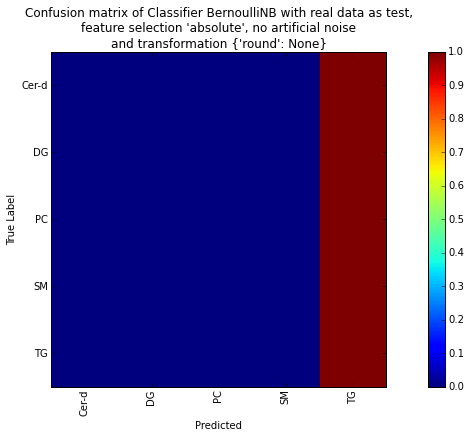


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:14:15 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 7.67899990082 seconds
fit predict 


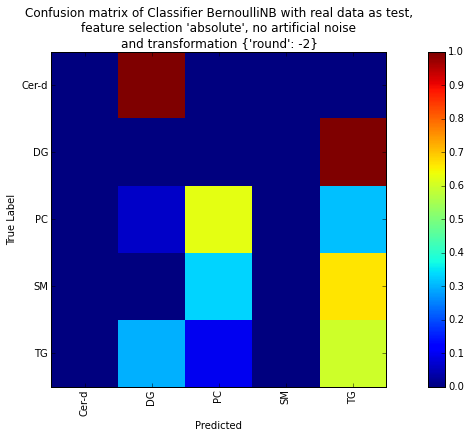


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:14:23 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 8.08000016212 seconds
fit predict 


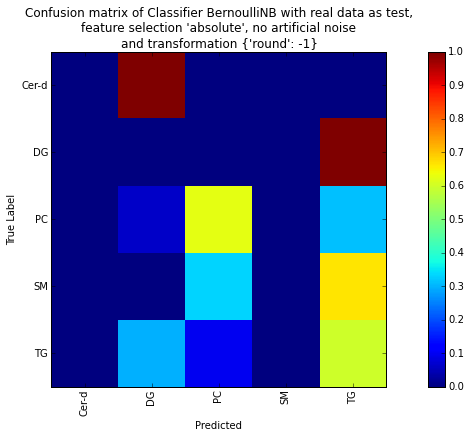


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:14:32 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 8.41499996185 seconds
fit predict 


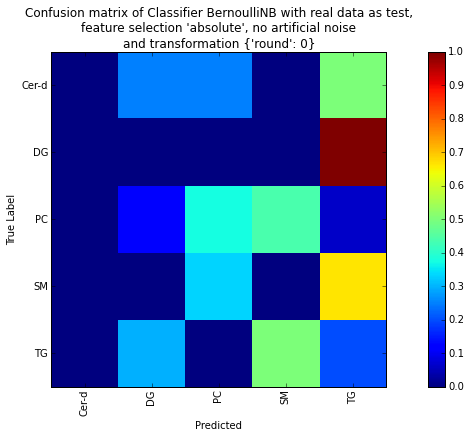


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:14:41 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 7.84699988365 seconds
fit predict 


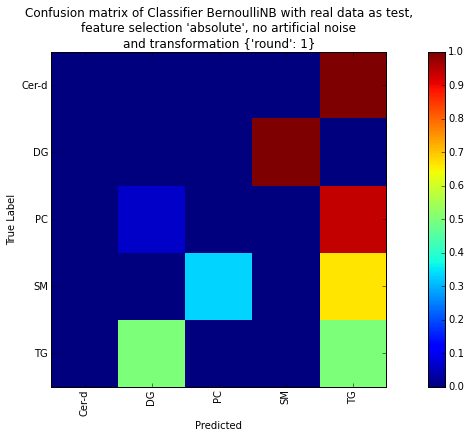




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.05      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.03      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.04      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.04      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.04      14.71        0


5/5 tests completed successfully in 42.1649999619 seconds




1,2-Dierucoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformati

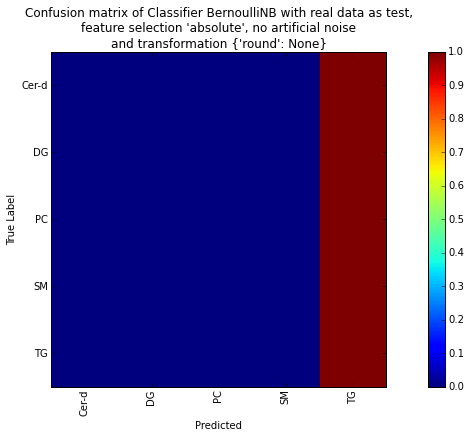


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:14:59 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 11.5020000935 seconds
fit predict 


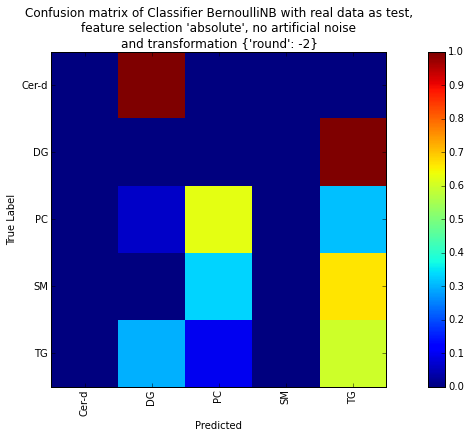


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:15:11 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 8.81599998474 seconds
fit predict 


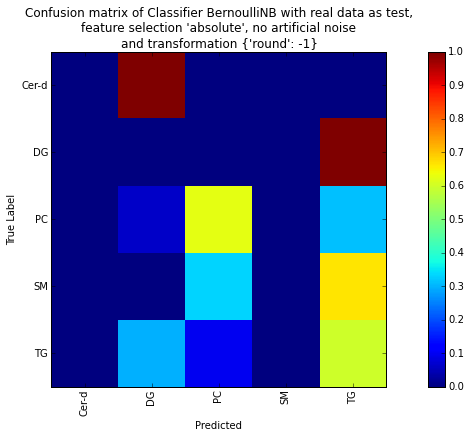


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:15:20 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 8.5490000248 seconds
fit predict 


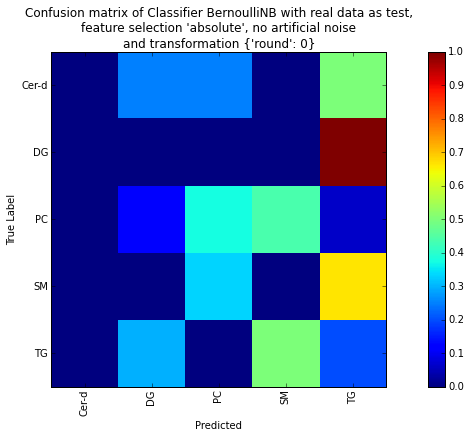


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:15:29 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 8.46099996567 seconds
fit predict 


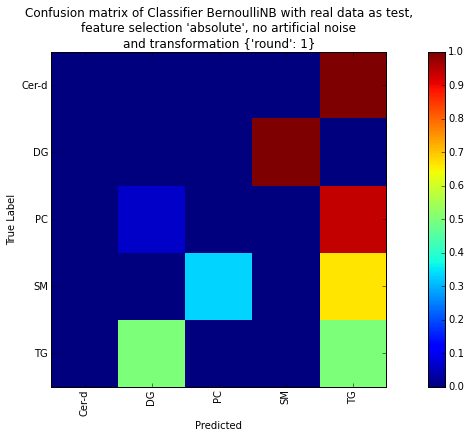




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.05      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.04      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.06      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.03      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.03      14.71        0


5/5 tests completed successfully in 49.5449998379 seconds




1,2-Dierucoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformati

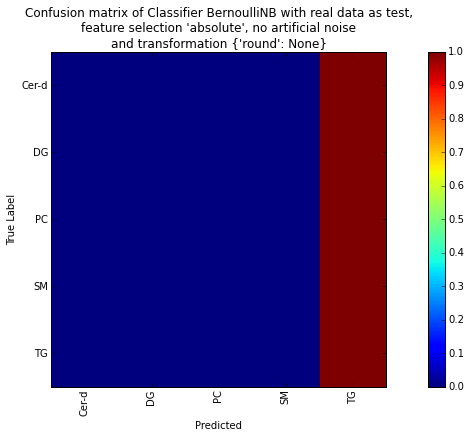


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:15:46 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 6.55799984932 seconds
fit predict 


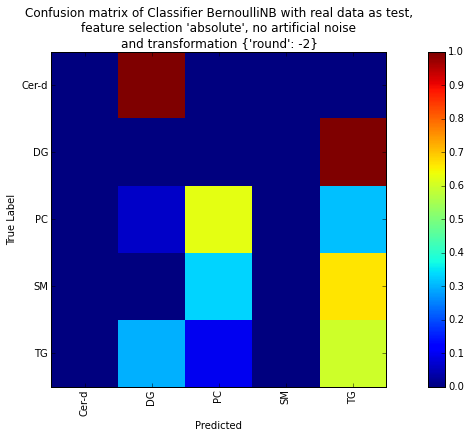


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:15:53 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 7.66300010681 seconds
fit predict 


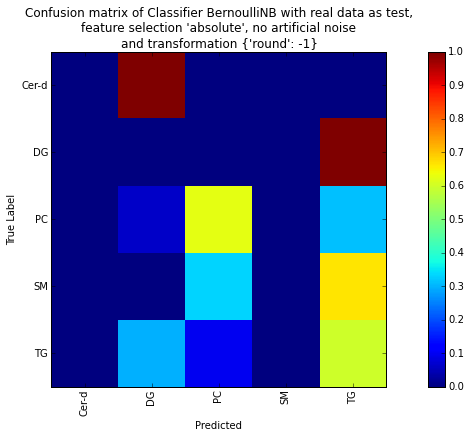


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:16:01 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 6.47199988365 seconds
fit predict 


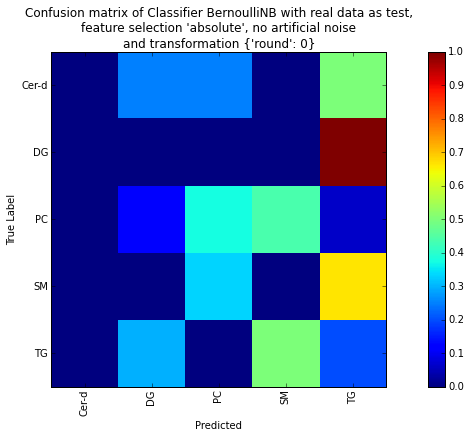


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:16:08 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 6.47300004959 seconds
fit predict 


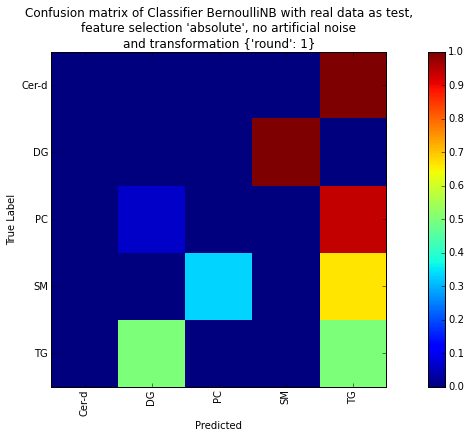




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.02      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.03      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.03      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.04      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.03      14.71        0


5/5 tests completed successfully in 36.2229998112 seconds




1,2-Dierucoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformati

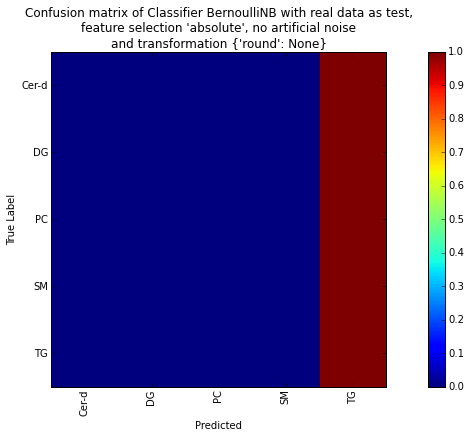


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:16:23 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 6.19000005722 seconds
fit predict 


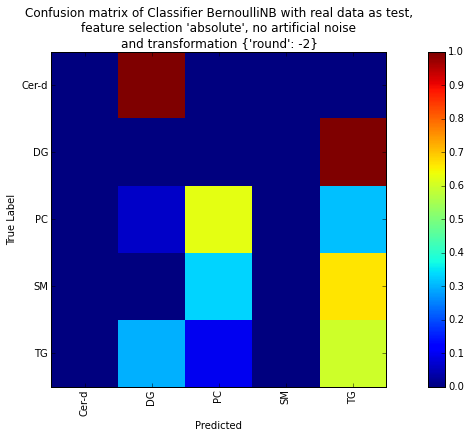


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:16:29 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 6.70500016212 seconds
fit predict 


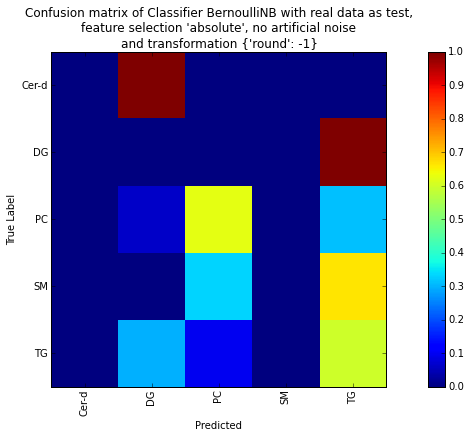


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:16:36 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 6.21599984169 seconds
fit predict 


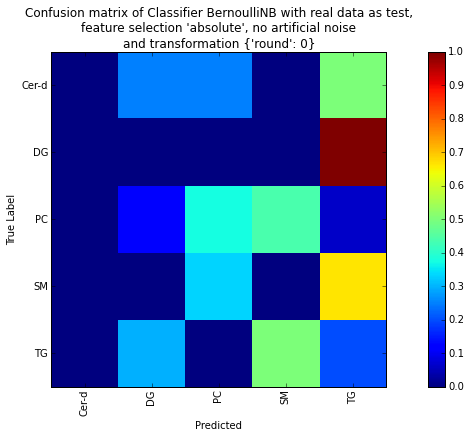


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:16:43 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 6.28800010681 seconds
fit predict 


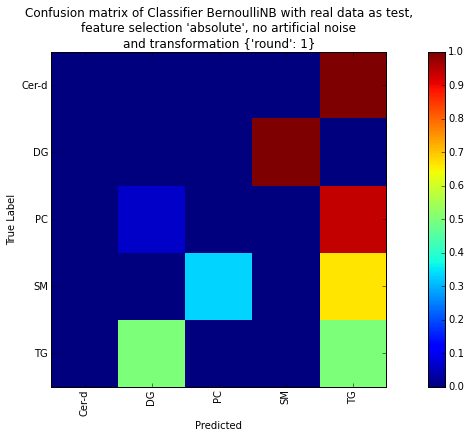




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.03      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.03      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.03      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.03      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.03      14.71        0


5/5 tests completed successfully in 34.8469998837 seconds




1,2-Dierucoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformati

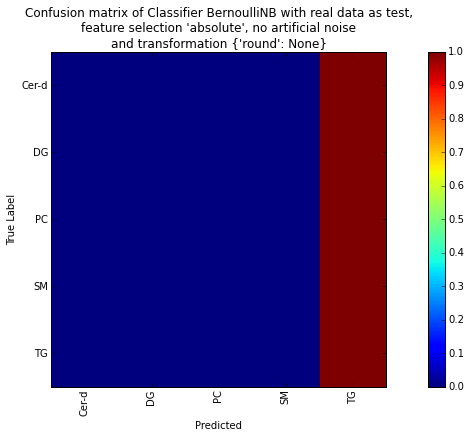


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:16:57 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 6.94799995422 seconds
fit predict 


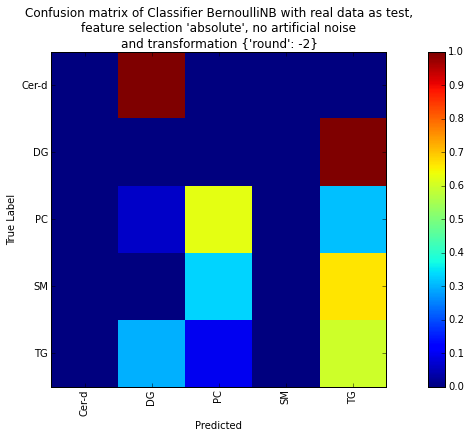


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:17:04 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 8.77999997139 seconds
fit predict 


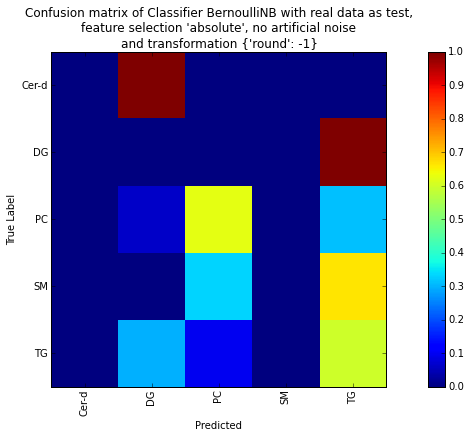


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:17:13 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 6.58700013161 seconds
fit predict 


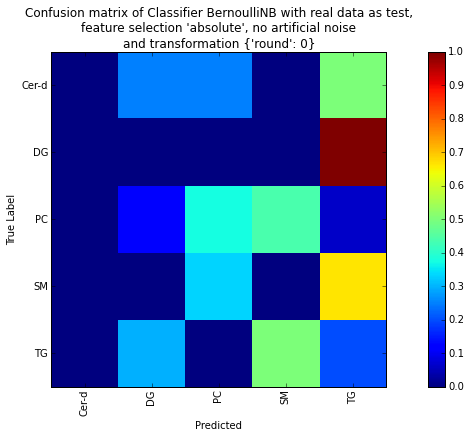


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:17:20 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 7.22600007057 seconds
fit predict 


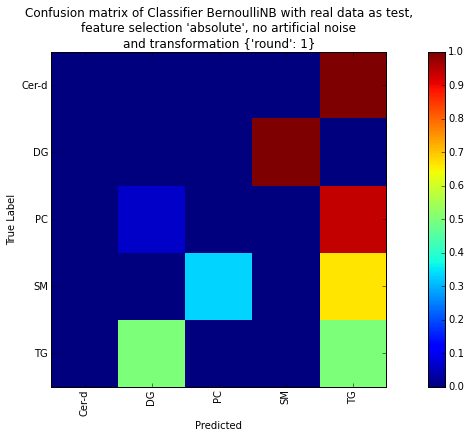




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.03      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.03      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.02      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.03      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.04      14.71        0


5/5 tests completed successfully in 38.4140000343 seconds




1,2-Dioleoyl-rac-glycerolNH4
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformation_test': {'r

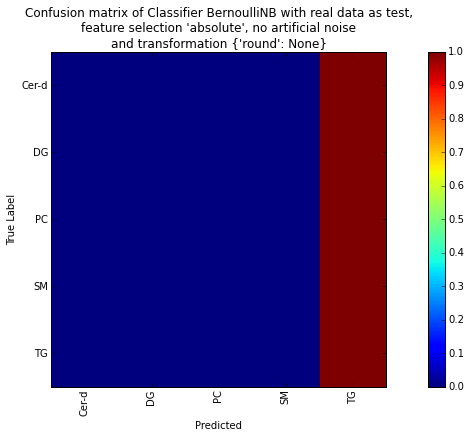


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:17:35 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 5.9470000267 seconds
fit predict 


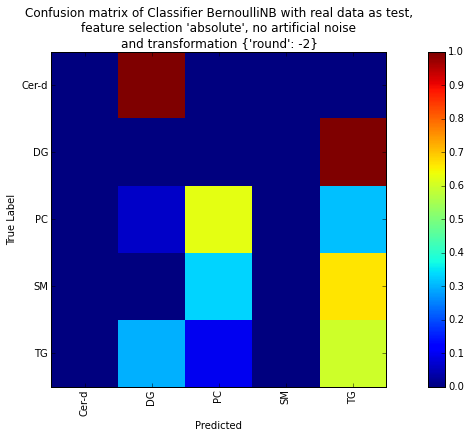


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:17:42 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 6.28999996185 seconds
fit predict 


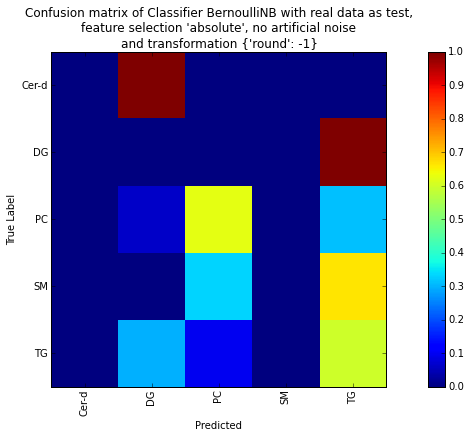


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:17:48 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 6.11199998856 seconds
fit predict 


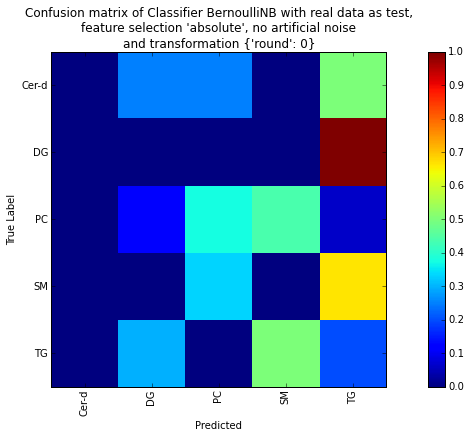


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:17:55 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 5.98500013351 seconds
fit predict 


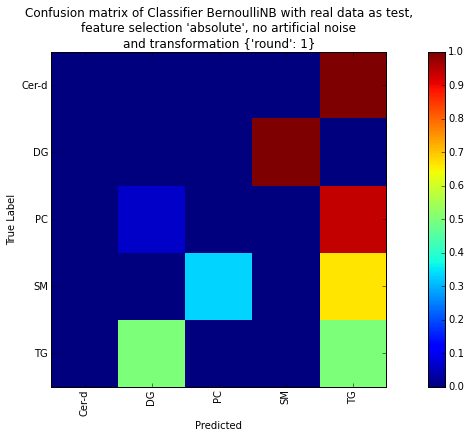




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.03      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.03      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.03      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.03      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.03      14.71        0


5/5 tests completed successfully in 33.0889999866 seconds




1-Oleoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformation_te

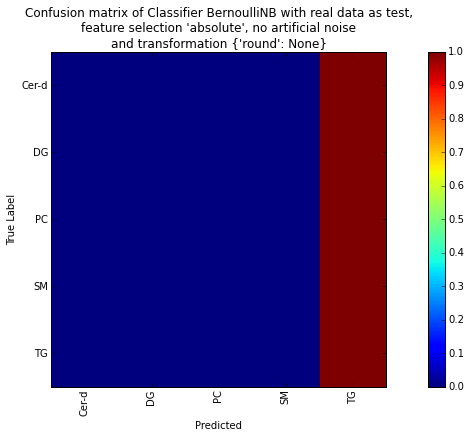


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:18:07 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 6.20700001717 seconds
fit predict 


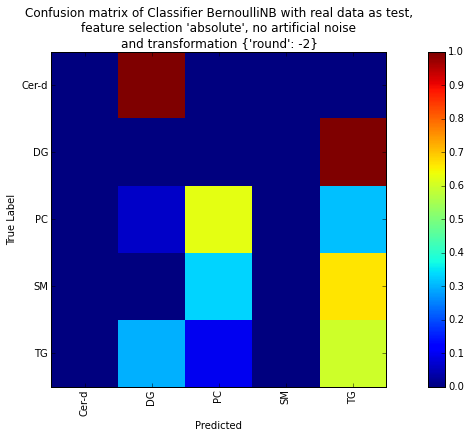


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:18:14 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 5.85100007057 seconds
fit predict 


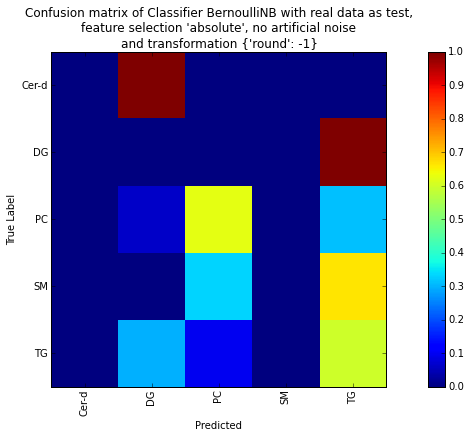


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:18:20 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 6.15500020981 seconds
fit predict 


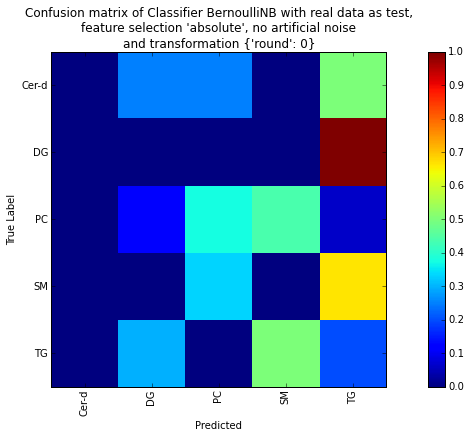


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:18:27 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 7.25500011444 seconds
fit predict 


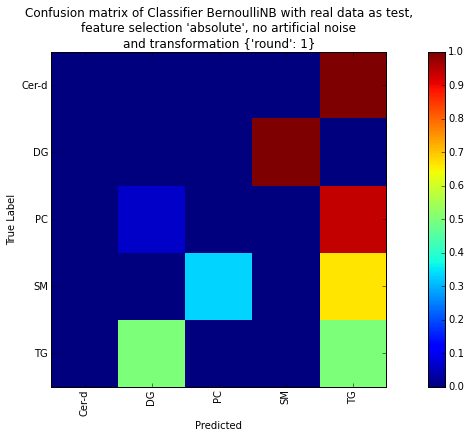




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.04      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.03      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.03      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.03      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.04      14.71        0


5/5 tests completed successfully in 33.4369997978 seconds




1-Oleoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformation_te

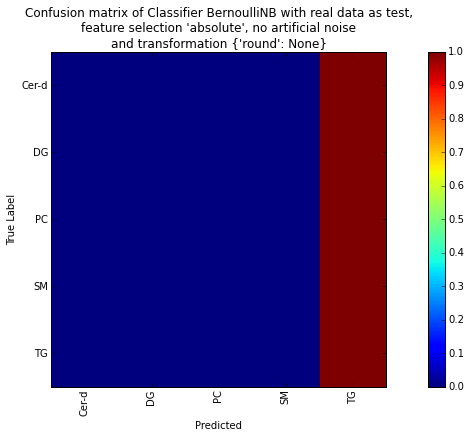


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:18:41 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 6.78099989891 seconds
fit predict 


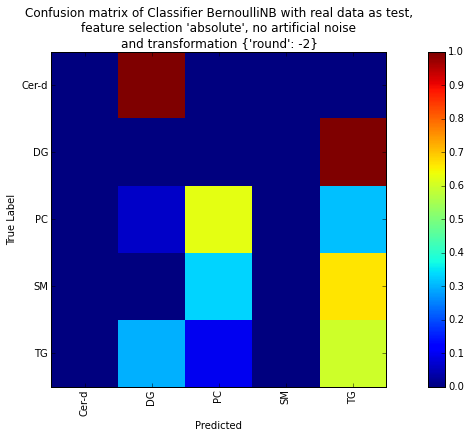


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:18:48 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 6.38700008392 seconds
fit predict 


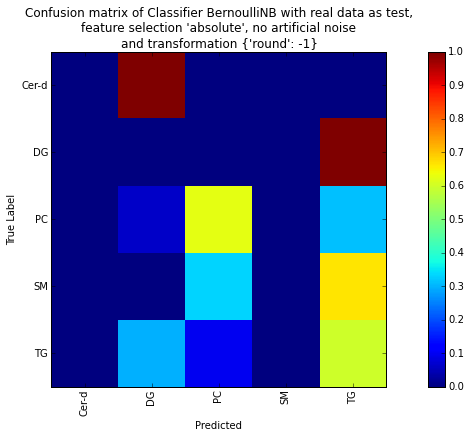


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:18:55 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 6.79600000381 seconds
fit predict 


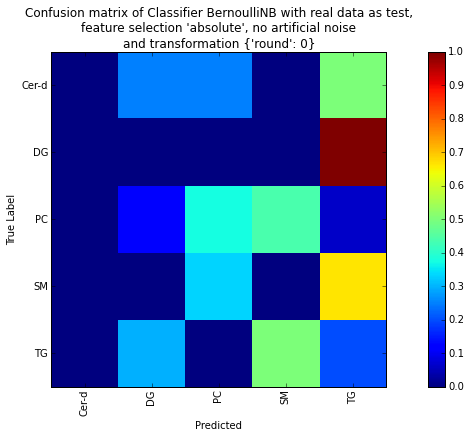


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:19:03 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 6.09500002861 seconds
fit predict 


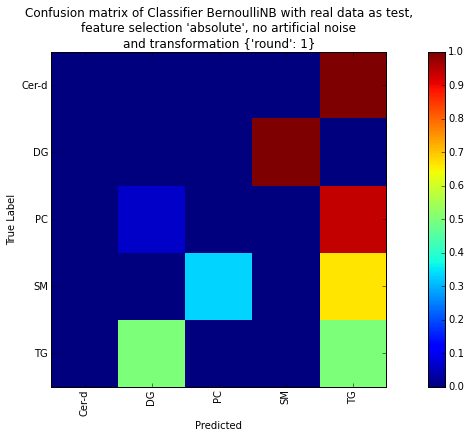




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.02      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.02      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.03      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.03      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.03      14.71        0


5/5 tests completed successfully in 34.6070001125 seconds




1-Oleoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformation_te

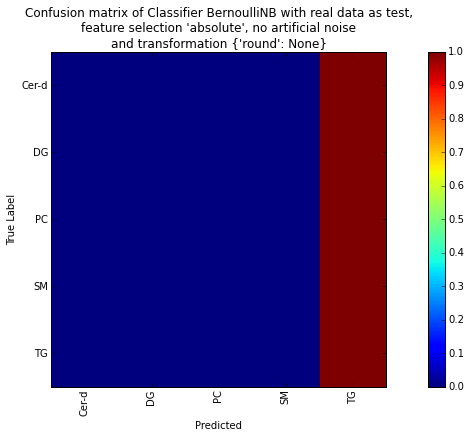


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:19:16 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space
Feature space generated in 6.48799991608 seconds
fit predict 


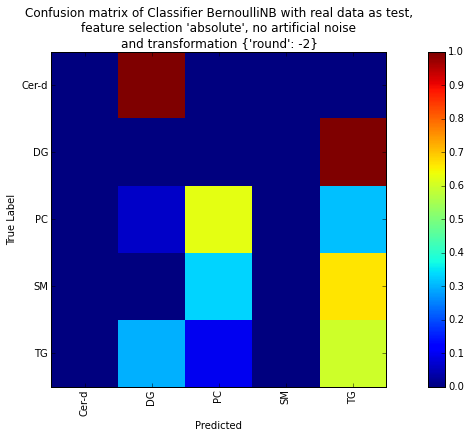


Running test 3/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -1, 'transformation_test': {'round': -1}} (started Thu Mar 03 23:19:23 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -1},{'round': -1}
Adding noise {} and transformation {'round': -1} to the feature space
Adding noise {} and transformation {'round': -1} to the test feature space
Feature space generated in 6.0119998455 seconds
fit predict 


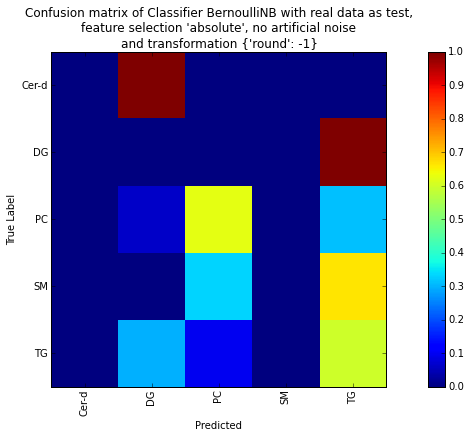


Running test 4/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 0, 'transformation_test': {'round': 0}} (started Thu Mar 03 23:19:29 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 0},{'round': 0}
Adding noise {} and transformation {'round': 0} to the feature space
Adding noise {} and transformation {'round': 0} to the test feature space
Feature space generated in 6.375 seconds
fit predict 


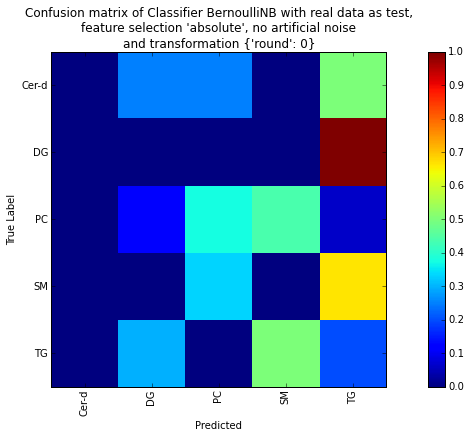


Running test 5/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': 1, 'transformation_test': {'round': 1}} (started Thu Mar 03 23:19:36 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': 1},{'round': 1}
Adding noise {} and transformation {'round': 1} to the feature space
Adding noise {} and transformation {'round': 1} to the test feature space
Feature space generated in 7.11400008202 seconds
fit predict 


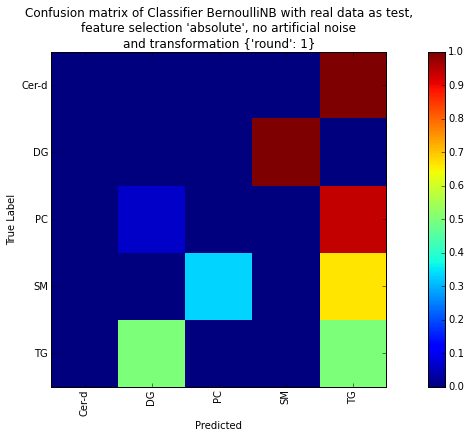




  #  Classifier            noise    feature transformation      folds    t/fold [s]    correct    sigma
---  --------------------  -------  ------------------------  -------  ------------  ---------  -------
  0  BernoulliNB (0.017 )  0 / 0    {'round': None}                            0.02      29.41        0
  1  BernoulliNB (0.017 )  0 / 0    {'round': -2}                              0.03      47.06        0
  2  BernoulliNB (0.017 )  0 / 0    {'round': -1}                              0.03      47.06        0
  3  BernoulliNB (0.017 )  0 / 0    {'round': 0}                               0.02      23.53        0
  4  BernoulliNB (0.017 )  0 / 0    {'round': 1}                               0.03      14.71        0


5/5 tests completed successfully in 34.4349999428 seconds




1-Oleoyl-sn-glycero-3-phosphocholine
Running test 1/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': None, 'transformation_te

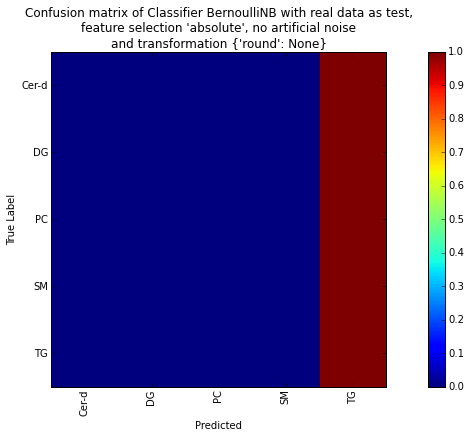


Running test 2/5: Classifier BernoulliNB with real data as test, feature selection 'absolute', no artificial noise and transformation {'round': -2, 'transformation_test': {'round': -2}} (started Thu Mar 03 23:19:51 2016)
Regenerating full feature space absolute with noise {},{} and transformation {'round': -2},{'round': -2}
Adding noise {} and transformation {'round': -2} to the feature space
Adding noise {} and transformation {'round': -2} to the test feature space

In [ ]:
# run test for compounds individually
for n, c in zip(full_names, compounds_test):
    print(n)
    T = ClassificationTest.ClassificationTest(compounds=needed, 
                                          compounds_test=compounds_test)
    for rounded in [None,-2,-1,0,1]:
        T.add_test(nb, transformation={"round":rounded}, transformation_test={"round":rounded})
    T.run()
    print("\n\n\n")

In [ ]:
# generate all combinations of taken peaks and round levels for diagrams on real data
Ts=[]
for takepeaks in [1,2,3,5,10]:
    compounds_test = [pl.Compound(m.common_name, None, 
                      float(s.weight[0]), None, None, 
                      sorted(list(s.mzs))[-takepeaks:], list(s.ints), None) 
                      for s, m in zip(full_spectra, full_maps)] 

    T = ClassificationTest.ClassificationTest(compounds=needed, 
                                              compounds_test=compounds_test, 
                                              save='results/real_data/5takepeaks_{}'.format(takepeaks))
    cls = [
        BernoulliNB(alpha=0.017),
        RidgeClassifier(),
        Perceptron(),
        svm.LinearSVC(penalty="l1", dual=False, tol=1e-3),
    ]
    T.clear()
    for add_peaks in [0,10,20]:
        for rounded in [-2,-1,0,1,2,3,None]:
            for cl in cls:
                for _ in range(5):
                    T.add_test(cl, noise={"add_random_peaks": add_peaks}, 
                               transformation={"round":rounded}, 
                               transformation_test={"round":rounded},
                               description={"take_peaks":takepeaks},
                               save_immediately=False)
                
    T.save_state()
    T.run(intermediate_result=False, output_confusion=False, output_process=False)
    Ts.append(T)